In [1]:
import os
import math
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt

from utils.preprocess_torchaudio import normalize_tensor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split


# Set the device to gpu if possible else to cpu
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(DEVICE)
if torch.cuda.is_available():
    print('GPU : ', torch.cuda.get_device_name())

GPU :  NVIDIA GeForce GTX 1660 Ti


In [2]:
# audio parameters
sample_rate=22050
hop_length = 512
n_fft = 512

# model parameters
num_layers = 4
hidden_size = 50
num_classes = 6
dropout = 0.25
lr = 0.003
num_epochs = 100

inner_linear_size = [2000,100]

In [4]:
X = torch.load('../../data/mel_spec_wav_6.pt')
Y = torch.load('../../data/target_mel_spec_wav_6.pt')


# print(X[0])

normalized = True
X = normalize_tensor(X)
# print(X[0])

print(X.shape)
print(Y.shape)

sequence_length = X.shape[1]
input_size = X.shape[2]

torch.Size([20138, 128, 94])
torch.Size([20138, 6])


In [5]:
batch_size = 64

dataset = TensorDataset(X, Y)
train_size = int(len(Y) * 0.8)
test_size = len(Y) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
print(f'train set size : {len(train_dataset)}')
print(f'test set size : {len(test_dataset)}')

train set size : 16110
test set size : 4028


In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, sequence_length, dropout, inner_linear_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.sequence_length = sequence_length
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(p=0.15)
        self.fc1 = nn.Linear(hidden_size*sequence_length, inner_linear_size[0])
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(inner_linear_size[0], inner_linear_size[1])
        self.fc3 = nn.Linear(inner_linear_size[1], num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, (_,_) = self.lstm(x, (h0, c0))
        # out = self.fc(out[:, -1, :])
        out = out.reshape(out.shape[0], -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [7]:
lstm = LSTM(input_size, hidden_size, num_layers, num_classes, sequence_length, dropout, inner_linear_size)
lstm.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=lr)


# np.nan si non utilisé
scheduler_milestone = [30, 55, 80]
scheduler_gamma = 1/3
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=scheduler_milestone, gamma=scheduler_gamma)

In [8]:
num_params = sum(p.numel() for p in lstm.parameters() if p.requires_grad)
print(num_params)

13093106


In [9]:
loss_trace_y = []
test_accuracy_trace_y = []
train_accuracy_trace_y = []

# Training loop
for epoch in range(num_epochs):
    lstm.train()
    loss_t = 0
    nb_just = 0
    nb = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = lstm(data)        
        loss = criterion(output, target)
        nb_just += torch.sum(torch.argmax(output,axis=1) == torch.argmax(target,axis=1))
        nb += output.shape[0]
        loss.backward()
        optimizer.step()
        loss_t += loss.item()
        
    scheduler.step()

    acc = nb_just/nb
    epoch_loss = loss_t/(batch_idx+1)
    loss_trace_y.insert(epoch, epoch_loss)
    train_accuracy_trace_y.insert(epoch, acc.detach().cpu().numpy().item())
    if epoch+1 == 1 or (epoch+1)%10 == 0:
        # \t lr: {scheduler.get_last_lr()[0]:.5f}
        print(f'Train Epoch: {epoch+1}/{num_epochs}\tLoss: {epoch_loss:.6f}\t lr: {scheduler.get_last_lr()[0]:.5f}')
        print(f"Accuracy sur le train: {acc:.4f}")
        
    lstm.eval()

    nb_just = 0
    nb = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        output = lstm(data)
        nb_just += torch.sum(torch.argmax(output,axis=1) == torch.argmax(target,axis=1))
        nb += output.shape[0]
    
    acc = nb_just/nb
    test_accuracy_trace_y.insert(epoch, acc.detach().cpu().numpy().item())
    if epoch+1 == 1 or (epoch+1)%10 == 0:
        print(f"Accuracy sur le test: {acc:.4f}")

Train Epoch: 1/100	Loss: 1.811623	 lr: 0.00300
Accuracy sur le train: 0.1689
Accuracy sur le test: 0.1703
Train Epoch: 10/100	Loss: 0.227597	 lr: 0.00300
Accuracy sur le train: 0.9161
Accuracy sur le test: 0.9094
Train Epoch: 20/100	Loss: 0.096533	 lr: 0.00300
Accuracy sur le train: 0.9637
Accuracy sur le test: 0.9434
Train Epoch: 30/100	Loss: 0.064765	 lr: 0.00100
Accuracy sur le train: 0.9769
Accuracy sur le test: 0.9481
Train Epoch: 40/100	Loss: 0.011579	 lr: 0.00100
Accuracy sur le train: 0.9965
Accuracy sur le test: 0.9558
Train Epoch: 50/100	Loss: 0.012483	 lr: 0.00100
Accuracy sur le train: 0.9957
Accuracy sur le test: 0.9551
Train Epoch: 60/100	Loss: 0.001744	 lr: 0.00033
Accuracy sur le train: 0.9994
Accuracy sur le test: 0.9610
Train Epoch: 70/100	Loss: 0.003214	 lr: 0.00033
Accuracy sur le train: 0.9992
Accuracy sur le test: 0.9605
Train Epoch: 80/100	Loss: 0.001920	 lr: 0.00011
Accuracy sur le train: 0.9993
Accuracy sur le test: 0.9613
Train Epoch: 90/100	Loss: 0.000170	 lr

In [15]:
# PATH =  './../models/lstm-V5.pth'
# torch.save(lstm.state_dict(), PATH)

# model = LSTM(input_size, hidden_size, num_layers, num_classes, sequence_length, dropout)
# model.to(device)
# model.load_state_dict(torch.load(PATH))

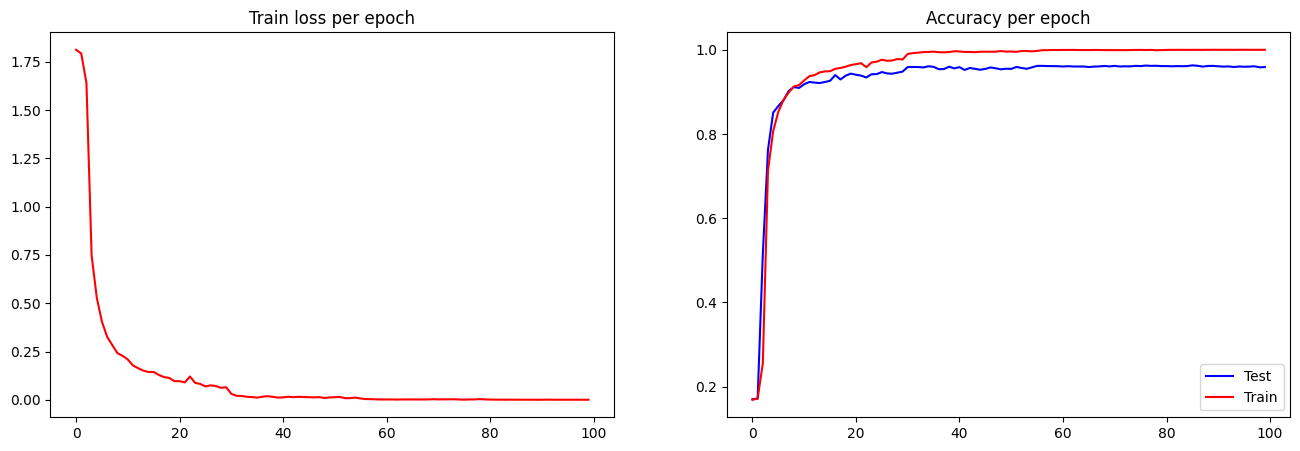

In [11]:
# Plot accuracy and loss graphs captured during the training process.
fig, ax = plt.subplots(1,2,figsize=(16, 5))
ax[0].set_title('Train loss per epoch')
ax[0].plot(loss_trace_y, color='red', label='Loss')

ax[1].set_title('Accuracy per epoch')
ax[1].plot(test_accuracy_trace_y, color='blue', label='Test')
ax[1].plot(train_accuracy_trace_y, color='red', label='Train')
plt.legend()

plt.show()

Archivage CSV

In [12]:
# csv containing all experiment result

# audio : sample rate / n_fft / hop_length
# model : input_size / sequence_length / hidden_size / num_layers / dropout
# training : learning_rate / num_epochs / batch_size / train_size / test_size / normalized / scheduler
# result : accuracy / loss

if not os.path.exists('./lstm_result.csv'):
    result = pd.DataFrame(columns=['sample_rate', 'n_fft', 'hop_length', 'input_size', 'sequence_length', 'hidden_size', 'num_layers', 'dropout', 'inner_linear_size', 'learning_rate', 'num_epochs', 'batch_size', 'train_size', 'test_size', 'normalized', 'scheduler_milestone', 'scheduler_gamma', 'test_accuracy', 'train_accuracy', 'train_loss'])
else:
    result = pd.read_csv('./lstm_result.csv', sep=';')

new_id = len(result)
new_result = [sample_rate, n_fft, hop_length, input_size, sequence_length, hidden_size, num_layers, dropout, str(inner_linear_size), lr, num_epochs, batch_size, len(train_dataset), len(test_dataset), str(normalized), str(scheduler_milestone).upper(), str(scheduler_gamma).upper(), str(test_accuracy_trace_y), str(train_accuracy_trace_y), str(loss_trace_y)]

if (new_id == 0 or not result.isin(new_result).iloc[-1].values.all()):
    result.loc[new_id] = new_result

result.to_csv('./lstm_result.csv', index=False, sep=';')

In [13]:
result = pd.read_csv('./lstm_result.csv', sep=';')

# string to array
result['test_accuracy'] = result['test_accuracy'].apply(literal_eval)

print('Last accuracy per attempt : ')

for i, acc in enumerate(result['test_accuracy']):
    print(f'{i}: {(acc[-1]*100):.4} %')

Last accuracy per attempt : 
0: 71.81 %
1: 72.5 %
2: 74.81 %
3: 62.16 %
4: 63.43 %
5: 16.7 %
6: 73.48 %
7: 73.37 %
8: 73.54 %
9: 69.09 %
10: 77.87 %
11: 77.3 %
12: 76.49 %
13: 75.45 %
14: 79.15 %
15: 77.01 %
16: 76.31 %
17: 78.16 %
18: 77.82 %
19: 77.12 %
20: 77.24 %
21: 71.58 %
22: 72.73 %
23: 78.05 %
24: 77.99 %
25: 75.33 %
26: 77.82 %
27: 76.95 %
28: 76.37 %
29: 73.83 %
30: 75.45 %
31: 78.22 %
32: 91.13 %
33: 92.05 %
34: 92.66 %
35: 91.01 %
36: 90.67 %
37: 89.97 %
38: 92.11 %
39: 91.25 %
40: 92.17 %
41: 90.38 %
42: 90.15 %
43: 90.75 %
44: 91.16 %
45: 89.89 %
46: 88.24 %
47: 90.99 %
48: 93.07 %
49: 93.21 %
50: 93.85 %
51: 93.15 %
52: 90.15 %
53: 92.23 %
54: 92.69 %
55: 93.33 %
56: 93.47 %
57: 93.79 %
58: 93.33 %
59: 94.77 %
60: 93.9 %
61: 94.02 %
62: 93.85 %
63: 93.21 %
64: 92.95 %
65: 94.16 %
66: 94.42 %
67: 95.65 %
68: 58.64 %
69: 95.22 %
70: 95.72 %
71: 95.9 %


In [14]:
result = pd.read_csv('./lstm_result.csv', sep=';')

result

,sample_rate,n_fft,hop_length,input_size,sequence_length,hidden_size,num_layers,dropout,inner_linear_size,learning_rate,num_epochs,batch_size,train_size,test_size,normalized,scheduler_milestone,scheduler_gamma,test_accuracy,train_accuracy,train_loss
0,22050,512,512,465,128,50,2,0.20,NAN,0.001,200,32,6921,1731,False,NAN,NAN,"[0.462160587310791, 0.5621027946472168, 0.6135...","[1.5966350790542392, 1.240263232987048, 1.1399...",NaN
1,22050,512,512,465,128,50,2,0.20,NAN,0.001,200,32,6921,1731,False,NAN,NAN,"[0.4378971457481384, 0.5280184745788574, 0.608...","[1.6466971394103793, 1.2747771349920105, 1.164...",NaN
2,22050,512,512,465,128,50,4,0.20,NAN,0.001,200,32,6921,1731,False,NAN,NAN,"[0.43443095684051514, 0.5314846634864807, 0.55...","[1.643230884855244, 1.3102105092343097, 1.2417...",NaN
3,22050,512,512,465,128,50,6,0.20,NAN,0.001,200,32,6921,1731,False,NAN,NAN,"[0.41016751527786255, 0.3968803882598877, 0.35...","[1.4655724022245626, 1.4232893989932152, 1.425...",NaN
4,22050,512,512,465,128,50,6,0.20,NAN,0.001,200,32,6921,1731,False,NAN,NAN,"[0.3269786238670349, 0.4511842727661133, 0.470...","[1.7858613097722629, 1.5228676988232521, 1.443...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,22050,512,512,94,128,50,4,0.25,"[2000, 100]",0.003,100,64,16164,4042,True,"[30, 55, 80]",0.3333333333333333,"[0.7439386248588562, 0.8171696662902832, 0.834...","[0.4686340093612671, 0.7615689039230347, 0.816...","[1.2668369944858928, 0.6390805747433613, 0.493..."
68,22050,512,512,94,128,50,4,0.25,"[2000, 100]",0.003,100,64,20763,5191,True,"[30, 55, 80]",0.3333333333333333,"[0.6821421384811401, 0.7125794291496277, 0.713...","[0.7150700688362122, 0.7104464769363403, 0.709...","[0.8978916510251852, 0.7509064116844764, 0.719..."
69,22050,512,512,94,128,50,4,0.25,"[2000, 100]",0.003,100,64,18417,4605,True,"[30, 55, 80]",0.3333333333333333,"[0.7218241095542908, 0.7993485331535339, 0.833...","[0.4273768663406372, 0.7657598853111267, 0.825...","[1.3569411567101877, 0.6334002287023597, 0.477..."
70,22050,512,512,94,128,50,4,0.25,"[2000, 100]",0.003,100,64,18417,4605,True,"[30, 55, 80]",0.3333333333333333,"[0.7437567710876465, 0.8045602440834045, 0.849...","[0.5083346962928772, 0.7635337114334106, 0.822...","[1.1862252447754145, 0.6332330753405889, 0.484..."
